In [24]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [25]:
import numpy as np
import pandas as pd

In [26]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [27]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [28]:
 # Create engine using the given`hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [29]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [30]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [31]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [32]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]

print(last_date)



2017-08-23


In [34]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.datetime.strptime(last_date, "%Y-%m-%d") - dt.timedelta(days=366)
print(last_year)


2016-08-22 00:00:00


In [35]:
# Perform a query to retrieve the data and precipitation scores
retrieve_data_scores = session.query(Measurement.date, 
                                        Measurement.prcp).filter(Measurement.date >= last_year).all()




In [38]:
# Save the query results as a Pandas DataFrame and set the index to the date column
retrieve_data_scores_df = pd.DataFrame(retrieve_data_scores, columns =['date', 'prcp'])

# Change datatype to datetime object
retrieve_data_scores_df['date'] = pd.to_datetime(retrieve_data_scores_df['date'], format='%Y-%m-%d')

#Set the index to date column
retrieve_data_scores_df.set_index('date', inplace=True)

In [39]:
# Sort the dataframe by date

retrieve_data_scores_df = retrieve_data_scores_df.sort_values(by='date',ascending=True)


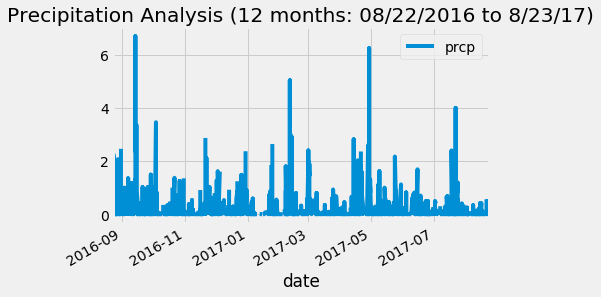

In [104]:
# Use Pandas Plotting with Matplotlib to plot the data
retrieve_data_scores_df.plot(title="Precipitation Analysis (12 months: 08/22/2016 to 8/23/17)")
plt.legend(loc='upper right')
plt.savefig("Images/Precipitation.png")
plt.show()

![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
retrieve_data_scores_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
Stations_in_dataset = session.query (Measurement).group_by(Measurement.station).distinct().count()

[(Stations_in_dataset)]


[9]

In [43]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

List_most_active_stations = session.query(Measurement.station, 
    func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(f"Below is a list of most Active Stations")
List_most_active_stations
    

Below is a list of most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [66]:
# To do the calculations in next cell, We need to first query for the station with most rows 
most_rows_station=List_most_active_stations[0][0]
# Just to add the specific name of the station, we query for the station name
stationName = (session.query(Station.name)
                      .filter_by(station = most_rows_station))
stationName = stationName[0][0]

print("The station with most rows is",most_rows_station,
      "whose specific name is", stationName, ". and it has",List_most_active_stations[0][1]," observations.")

The station with most rows is USC00519281 whose specific name is WAIHEE 837.5, HI US . and it has 2772  observations.


In [67]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).filter(Measurement.station == most_rows_station).all()

print(most_active_temps)

[(54.0, 85.0, 71.66378066378067)]


The chosen highest temperature is ('USC00519281', 2772)

Below is a histogram respresentation of last 12 months temp. observation


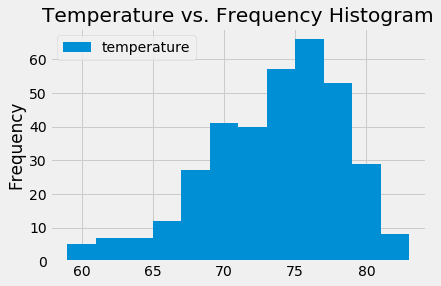

In [105]:
# Choose the station with the highest number of temperature observations.
highest_temp_station = session.query(Measurement.station, 
    func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
highest_temps_station= highest_temps_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query( Measurement.tobs).filter(Measurement.date > 
                                                        last_year).filter(Measurement.station == most_temps_station).all()

# Read the above query object into dataFrame
temp_observation_df = pd.DataFrame(temp_observation, columns=['temperature'])



#histogram plot with pandas
temp_observation_df.plot(kind='hist', bins=12, title="Temperature vs. Frequency Histogram")
plt.savefig("Images/station-histogram.png")

print(f"The chosen highest temperature is", highest_temp_station)
print()
print(f"Below is a histogram respresentation of last 12 months temp. observation")



![precipitation](Images/station-histogram.png)

In [94]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [95]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-01-01','2017-01-07')
trip


[(62.0, 68.36585365853658, 74.0)]

In [97]:
# Create a dataframe with the calculated tmin, tavg, and tmax values
trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

trip_temp_df


,tmin,tavg,tmax
0,62.0,68.365854,74.0


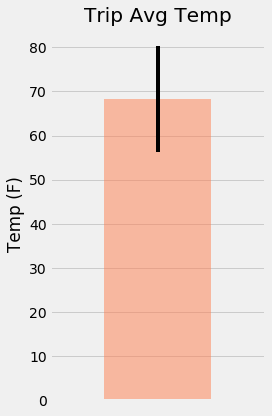

In [106]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/temperature.png")
plt.show()

In [99]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
        # Docstring for the function `calc_temps`
    """Precipitation information per weather station
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        A list of tuples containing precipitation amount, station, name, latitude, longitude, and elevation in descending order.
    """
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= 
                                                        start_date).filter(Measurement.date <= 
                                        end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-01-01','2017-01-07'))

[('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.29), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.03), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.03), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]


## Optional Challenge Assignment

In [100]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [101]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-01-01'
end_date ='2017-01-07'
# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= 
                                    start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
#List comprehension
trip_dates = [x[0] for x in dates]
# Stip off the year and save a list of %m-%d strings
trip_dates_stripped= [x[5:] for x in trip_dates]
# Find the start month/day and the end month/day 
start_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
    func.avg(Measurement.tobs),
                func.max(Measurement.tobs)).filter(func.strftime("%m-%d", 
                        Measurement.date) >= start_month_day).filter(func.strftime("%m-%d", 
                                Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", 
                                                                                           Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 01-01 to 01-07")
daily_normals

Aggregate Daily Normals for 01-01 to 01-07


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [102]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df.head()

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0


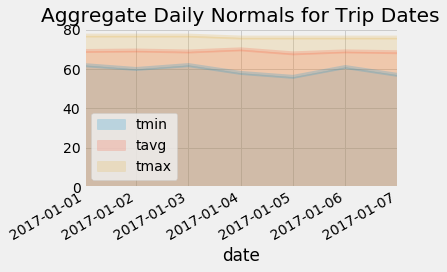

In [108]:
# Plot the daily normals as an area plot with `stacked=False`

# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
plt.savefig("Images/daily-normals.png")
plt.show()
